In [3]:
!pip install tensorflow

     |████████████████████████████████| 207.1 MB 41 kB/s  eta 0:00:01   |█                               | 6.8 MB 1.4 MB/s eta 0:02:23     |███▎                            | 21.4 MB 3.7 MB/s eta 0:00:50     |█████▉                          | 37.7 MB 6.7 MB/s eta 0:00:26     |██████                          | 38.5 MB 6.7 MB/s eta 0:00:26     |█████████▎                      | 59.8 MB 3.8 MB/s eta 0:00:39     |█████████▍                      | 60.6 MB 3.8 MB/s eta 0:00:39     |█████████▊                      | 63.2 MB 3.8 MB/s eta 0:00:38     |██████████████                  | 91.0 MB 5.7 MB/s eta 0:00:21     |██████████████████              | 116.2 MB 3.3 MB/s eta 0:00:28     |█████████████████████▏          | 137.1 MB 6.4 MB/s eta 0:00:11     |███████████████████████         | 149.3 MB 8.2 MB/s eta 0:00:08
     |████████████████████████████████| 4.2 MB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 5.1 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 1) добавьте лемматизацию в предобработку (любым способом)
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)
3) измените часть с np.random.randint(vocab_size) так, чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов (частотные должны выбираться реже, а редкие чаще)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [4]:
wiki = open('wiki_data.txt').read().split('\n')

### Prepocessing

In [5]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [6]:
def lemmatize(token):
    return morph.parse(token)[0].normal_form

In [7]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [lemmatize(token) for token in tokens]
    return tokens

In [8]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [9]:
len(vocab)

356181

In [10]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [11]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [12]:
len(word2id)

11988

In [13]:
id2word = {i:word for word, i in word2id.items()}

In [14]:
len(id2word)

11988

In [15]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [16]:
probs = dict()
summ = 0
for word in word2id.keys():
    summ += vocab[word]
for word in word2id.keys():
    probs[word] = (vocab[word] / summ)

In [17]:
len(probs)

11988

In [18]:
probs_id = dict()
for word in id2word.keys():
    probs_id[word] = probs[id2word[word]]

In [19]:
len(probs_id)

11988

In [20]:
inverse_probability = [(1-x) for x in probs_id.values()]
inverse_probability = [x/sum(inverse_probability) for x in inverse_probability]

In [21]:
from random import random
from bisect import bisect

In [22]:
def weighted_choice(values, weights):
    total = 0
    cum_weights = []
    for w in weights:
        total += w
        cum_weights.append(total)
    x = random() * total
    i = bisect(cum_weights, x)
    return values[i]

In [23]:
weighted_choice(list(probs_id.keys()), inverse_probability)

5630

### CBOW

In [24]:
X = []
y = []

window = 3
for sent in sentences[:10000]:
    for i in range(len(sent)-1):
        word = sent[i]
        context = sent[max(0, i-window):i] + sent[i+1:i+window]
        
        X.append(context)
        y.append(word)

In [25]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=10, padding='post')
y = np.array(y)

In [26]:
def gen_batches_cbow(sentences, probs_id, inverse_probability, window = 3, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.choice(list(probs_id.keys()), p=list(inverse_probability)))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [27]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_cbow = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
model_cbow.fit(gen_batches_cbow(sentences[:10000], probs_id=probs_id, inverse_probability=inverse_probability, window=3),
          validation_data=gen_batches_cbow(sentences[10000:],  probs_id=probs_id, inverse_probability=inverse_probability, window=3),
          batch_size=1000,
          steps_per_epoch=3000, # сократим кол-во эпох по сравнению с семинарским ноутбоком с целью экономии времени
          validation_steps=30,
         epochs=2)

Epoch 1/2
3000/3000 [==============================] - 3286s 1s/step - loss: 0.3966 - accuracy: 0.8266 - val_loss: 0.3357 - val_accuracy: 0.8605
Epoch 2/2
3000/3000 [==============================] - 3556s 1s/step - loss: 0.2912 - accuracy: 0.8779 - val_loss: 0.3206 - val_accuracy: 0.8692


In [29]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [30]:
embeddings_cbow = model_cbow.layers[2].get_weights()[0]

In [31]:
embeddings_cbow

array([[-0.09256264, -0.10522221, -0.2423701 , ..., -0.13536435,
         0.12548721, -0.27962732],
       [ 0.28593484, -0.07321586,  0.2217221 , ..., -0.07241136,
        -0.15677617,  0.00050351],
       [-0.15464914, -0.25474975,  0.03846047, ..., -0.10691462,
         0.04517775, -0.18664397],
       ...,
       [ 0.01009293, -0.06440275,  0.00217804, ..., -0.08373835,
         0.05932606, -0.051391  ],
       [-0.01898246, -0.02181384,  0.00190775, ..., -0.12379237,
         0.1503148 , -0.01319555],
       [ 0.09766469, -0.01888045, -0.08653955, ...,  0.07914654,
        -0.08541541, -0.23240344]], dtype=float32)

In [32]:
most_similar('окно', embeddings_cbow)

['окно',
 'вход',
 'цилиндр',
 'потолок',
 'крыша',
 'хвост',
 'труба',
 'шея',
 'купол',
 'закруглить']

In [33]:
most_similar('кот', embeddings_cbow)

['кот',
 'добродетель',
 'морган',
 'nature',
 'падеж',
 'коста',
 'лавров',
 'эйстейн',
 'ужасный',
 'син']

In [34]:
most_similar('город', embeddings_cbow)

['город', 'и', 'который', 'он', 'в', 'год', 'находиться', 'быть', 'они', 'к']

### Skip gram 

In [35]:
X = []
y = []

window = 6
for sent in sentences[:1000]:
    for i in range(len(sent)-1):
        word = sent[i] # target
        
        context = sent[max(0, i-window):i] + sent[i+1:i+window] 

        for context_word in context:
            X.append(word)
            y.append(context_word)

In [36]:
def gen_batches_sg(sentences, probs_id, inverse_probability, window = 6, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(weighted_choice(list(probs_id.keys()), inverse_probability))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [37]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_sg = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_sg.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [38]:
model_sg.fit(gen_batches_sg(sentences[:15000], probs_id=probs_id, inverse_probability=inverse_probability, window=6),
          validation_data=gen_batches_sg(sentences[15000:], probs_id=probs_id, inverse_probability=inverse_probability, window=6),
          batch_size=1000,
          steps_per_epoch=3000, #сократим немного кол-во эпох по сравнению с семинарским ноутбоком с целью экономии времени
          validation_steps=30,
         epochs=2)

Epoch 1/2
3000/3000 [==============================] - 2564s 855ms/step - loss: 0.4809 - accuracy: 0.7735 - val_loss: 0.4640 - val_accuracy: 0.7869
Epoch 2/2
3000/3000 [==============================] - 2705s 902ms/step - loss: 0.4336 - accuracy: 0.8085 - val_loss: 0.4776 - val_accuracy: 0.7721


In [39]:
embeddings_sg = model_sg.layers[2].get_weights()[0]

In [40]:
embeddings_sg

array([[-0.03297827,  0.00696015,  0.0129998 , ..., -0.00722482,
         0.03301695, -0.02863163],
       [ 0.03992031, -0.12455888,  0.05396245, ..., -0.03331076,
        -0.00309054, -0.09687902],
       [-0.0291925 , -0.05698509,  0.06512947, ..., -0.07354443,
        -0.06891669, -0.04191284],
       ...,
       [-0.03695882, -0.01447025, -0.0163949 , ..., -0.03749942,
        -0.01653888,  0.00991428],
       [-0.0038173 , -0.01112171,  0.02686433, ..., -0.03296201,
        -0.00583365, -0.04515998],
       [ 0.02586286, -0.02370535,  0.00365506, ...,  0.02523389,
         0.00619652, -0.02294052]], dtype=float32)

In [41]:
most_similar('окно', embeddings_sg)

['окно',
 'обычно',
 'сомнение',
 'соответствовать',
 'ударный',
 'внешний',
 'продольный',
 'именно',
 'размер',
 'крыло']

In [42]:
most_similar('кот', embeddings_sg)

['кот',
 'десяток',
 'фрейм',
 'белорус',
 'алюминий',
 'добиваться',
 'цин',
 'комментатор',
 'городище',
 'тренироваться']

In [43]:
most_similar('город', embeddings_sg)

['город',
 'село',
 'территория',
 'район',
 'находиться',
 'посёлок',
 'провинция',
 'административный',
 'берег',
 'центр']

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [44]:
import gensim

In [45]:
wiki = open('wiki_data.txt').read().split('\n')

In [46]:
texts = [preprocess(sent) for sent in wiki] # такой же preprocessing как в 1 задании (с лемматизацией)

### word2vec

In [47]:
w2v = gensim.models.Word2Vec(texts)

In [48]:
w2v = gensim.models.Word2Vec(texts, 
                             vector_size=200, 
                             min_count=15, 
                             max_vocab_size=10000,
                             ns_exponent=0.95,
                             sg=0, 
                             hs=1,
                             negative=7,
                             sample=1e-4,
                             cbow_mean=2,
                             window=4,
                             epochs=9)

In [49]:
w2v.wv.most_similar('город')

[('столица', 0.49953484535217285),
 ('центр', 0.43205347657203674),
 ('округ', 0.39966070652008057),
 ('район', 0.3872532844543457),
 ('городок', 0.38063108921051025),
 ('посёлок', 0.3792397379875183),
 ('улица', 0.3671080470085144),
 ('регион', 0.3664977252483368),
 ('окраина', 0.35392510890960693),
 ('будапешт', 0.3382840156555176)]

In [50]:
w2v.wv.most_similar('машина')

[('автомобиль', 0.5627382397651672),
 ('двигатель', 0.5343623757362366),
 ('шасси', 0.5189521908760071),
 ('кузов', 0.4925704896450043),
 ('модификация', 0.4712277948856354),
 ('модель', 0.4531000554561615),
 ('самолёт', 0.4172331392765045),
 ('мощность', 0.4114226698875427),
 ('топливо', 0.3959495425224304),
 ('колесо', 0.39452704787254333)]

### FastText

In [51]:
ft = gensim.models.FastText(texts)

In [52]:
ft = gensim.models.FastText(texts, 
                            min_n=5, 
                            max_n=9,
                            vector_size=200, 
                            min_count=15, 
                            max_vocab_size=10000,
                            ns_exponent=0.95,
                            sg=0, 
                            hs=1,
                            negative=7,
                            sample=1e-4,
                            cbow_mean=2,
                            window=4,
                            epochs=9
                           )

In [53]:
ft.wv.most_similar('город')

[('городок', 0.5525912046432495),
 ('столица', 0.5250776410102844),
 ('посёлок', 0.5025556683540344),
 ('окраина', 0.49057963490486145),
 ('близ', 0.48775985836982727),
 ('округ', 0.47743314504623413),
 ('район', 0.4649865925312042),
 ('провинция', 0.46067169308662415),
 ('центр', 0.4495885372161865),
 ('городской', 0.4307197630405426)]

In [54]:
ft.wv.most_similar('машина')

[('шасси', 0.5986820459365845),
 ('двигатель', 0.5922982096672058),
 ('кузов', 0.592245876789093),
 ('автомобиль', 0.5792157053947449),
 ('самолёт', 0.5024771094322205),
 ('модификация', 0.48331668972969055),
 ('модель', 0.4809717535972595),
 ('установка', 0.4684373736381531),
 ('топливо', 0.46802735328674316),
 ('мощность', 0.46682682633399963)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [90]:
data = pd.read_csv('labeled.csv')

In [92]:
data.shape

(14412, 3)

### Preprocessing

In [94]:
data['norm_text'] = data.comment.apply(preprocess)

In [95]:
data.sample(5)

,comment,toxic,norm_text
3065,"ворона, кар-кар-кар-кар-кар-кар-кар... А петух...",1.0,"[ворона, кар-кар-кар-кар-кар-кар-кар, а, петух..."
1481,мне вот интересно: на Большой земле примерно в...,0.0,"[я, вот, интересно, на, большой, земля, пример..."
10007,"Я ни разу не парашютист, подробности не знаю, ...",0.0,"[я, ни, раз, не, парашютист, подробность, не, ..."
8677,"Это как раз обычная тема, они в длинные госден...",0.0,"[это, как, раз, обычный, тема, они, в, длинный..."
11499,По промышленному дизайну пакеты не подскажу. И...,0.0,"[по, промышленный, дизайн, пакет, не, подсказа..."


In [115]:
vocab_lab = Counter()

for text in data['norm_text']:
    vocab_lab.update(text)

In [116]:
len(vocab_lab)

37922

In [127]:
word2id_lab = {'PAD': 0}

for word in vocab_lab:
    word2id_lab[word] = len(word2id_lab)

In [128]:
id2word_lab = {i: word for word, i in word2id_lab.items()}

In [129]:
print(len(word2id_lab)) 
print(len(id2word_lab))

37923
37923


In [130]:
X = []
for tokens in data['norm_text']:
    ids = [word2id_lab[token] for token in tokens if token in word2id_lab]
    X.append(ids)

In [131]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = labeled.toxic.values

In [132]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

## Эмбеддинги из 1 задания

### CBOW

In [170]:
weights_cbow = np.zeros((len(word2id_lab), 300))

for word, i in word2id_lab.items():

    if word == 'PAD':
        continue

    try:
        weights_cbow[i] = embeddings_cbow[word2id[word]]
    
    except KeyError:
        continue
        weights_cbow[i] = embeddings_cbow[word2id['опрагпллирао']]

In [171]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_lab), output_dim=300, 
                                       trainable=False,
                                       weights=[weights_cbow])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [172]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6393 - accuracy: 0.6665 - val_loss: 0.6287 - val_accuracy: 0.6526
Epoch 2/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6261 - accuracy: 0.6665 - val_loss: 0.6280 - val_accuracy: 0.6526
Epoch 3/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6251 - accuracy: 0.6665 - val_loss: 0.6276 - val_accuracy: 0.6526
Epoch 4/30
406/406 [==============================] - 1s 4ms/step - loss: 0.6243 - accuracy: 0.6665 - val_loss: 0.6272 - val_accuracy: 0.6526
Epoch 5/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6236 - accuracy: 0.6665 - val_loss: 0.6268 - val_accuracy: 0.6526
Epoch 6/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6230 - accuracy: 0.6665 - val_loss: 0.6263 - val_accuracy: 0.6526
Epoch 7/30
406/406 [==============================] - 1s 3ms/step - loss: 0.6225 - accuracy: 0.6665 - val_loss: 0.6259 - val_accuracy: 0.6526
Epoch 

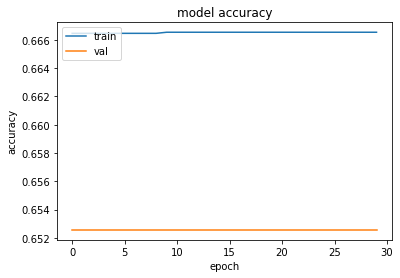

In [173]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Skip gram

In [137]:
weights_sg = np.zeros((len(word2id_lab), 300))

for word, i in word2id_lab.items():

    if word == 'PAD':
        continue

    try:
        weights_sg[i] = embeddings_sg[word2id[word]]
    
    except KeyError:
        continue
        weights_sg[i] = embeddings_sg[word2id['опрагпллирао']]

In [138]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_lab), output_dim=300, 
                                       trainable=False,
                                       weights=[weights_sg])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [139]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 3s 5ms/step - loss: 0.6381 - accuracy: 0.6662 - val_loss: 0.6280 - val_accuracy: 0.6526
Epoch 2/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6198 - accuracy: 0.6665 - val_loss: 0.6273 - val_accuracy: 0.6526
Epoch 3/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6195 - accuracy: 0.6665 - val_loss: 0.6272 - val_accuracy: 0.6526
Epoch 4/30
406/406 [==============================] - 3s 6ms/step - loss: 0.6193 - accuracy: 0.6665 - val_loss: 0.6271 - val_accuracy: 0.6526
Epoch 5/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6191 - accuracy: 0.6665 - val_loss: 0.6269 - val_accuracy: 0.6526
Epoch 6/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6189 - accuracy: 0.6665 - val_loss: 0.6267 - val_accuracy: 0.6526
Epoch 7/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6190 - accuracy: 0.6665 - val_loss: 0.6266 - val_accuracy: 0.6526
Epoch 

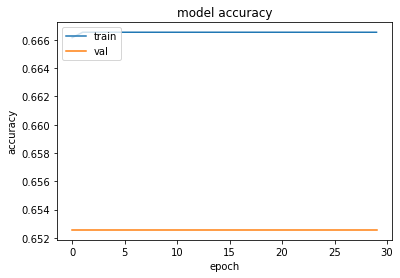

In [140]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Модели не обучаются... Очень плохие результаты. 

## Эмбеддинги из 2 задания (gensim)

### word2vec

In [141]:
weights_w2v = np.zeros((len(word2id_lab), 200))

for word, i in word2id_lab.items():

    if word == 'PAD':
        continue

    try:
        weights_w2v[i] = w2v.wv[word]
    
    except KeyError:
        continue
        weights_w2v[i] = w2v.wv['опрагпллирао']

In [142]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_lab), output_dim=200, 
                                       trainable=False,
                                       weights=[weights_w2v])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [143]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6304 - accuracy: 0.6652 - val_loss: 0.6185 - val_accuracy: 0.6519
Epoch 2/30
406/406 [==============================] - 2s 4ms/step - loss: 0.5981 - accuracy: 0.6662 - val_loss: 0.6001 - val_accuracy: 0.6519
Epoch 3/30
406/406 [==============================] - 2s 4ms/step - loss: 0.5819 - accuracy: 0.6695 - val_loss: 0.5857 - val_accuracy: 0.6574
Epoch 4/30
406/406 [==============================] - 2s 4ms/step - loss: 0.5694 - accuracy: 0.6749 - val_loss: 0.5747 - val_accuracy: 0.6713
Epoch 5/30
406/406 [==============================] - 2s 4ms/step - loss: 0.5596 - accuracy: 0.6892 - val_loss: 0.5662 - val_accuracy: 0.6796
Epoch 6/30
406/406 [==============================] - 1s 4ms/step - loss: 0.5516 - accuracy: 0.7001 - val_loss: 0.5586 - val_accuracy: 0.6921
Epoch 7/30
406/406 [==============================] - 2s 5ms/step - loss: 0.5449 - accuracy: 0.7081 - val_loss: 0.5523 - val_accuracy: 0.6997
Epoch 

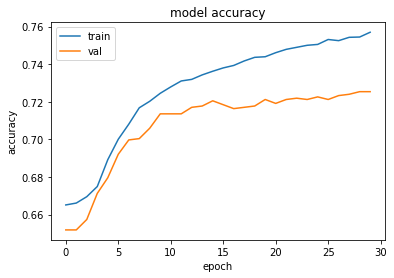

In [144]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Fastext

In [145]:
weights_ft = np.zeros((len(word2id_lab), 200))

for word, i in word2id_lab.items():

    if word == 'PAD':
        continue

    try:
        weights_ft[i] = ft.wv[word]
    
    except KeyError:
        continue
        weights_ft[i] = ft.wv['опрагпллирао']

In [146]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_lab), output_dim=200, 
                                       trainable=False,
                                       weights=[weights_ft])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [147]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 5ms/step - loss: 0.6201 - accuracy: 0.6556 - val_loss: 0.6071 - val_accuracy: 0.6533
Epoch 2/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5888 - accuracy: 0.6735 - val_loss: 0.5914 - val_accuracy: 0.6595
Epoch 3/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5746 - accuracy: 0.6814 - val_loss: 0.5821 - val_accuracy: 0.6671
Epoch 4/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5649 - accuracy: 0.6909 - val_loss: 0.5723 - val_accuracy: 0.6748
Epoch 5/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5571 - accuracy: 0.7000 - val_loss: 0.5669 - val_accuracy: 0.6838
Epoch 6/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5513 - accuracy: 0.7099 - val_loss: 0.5615 - val_accuracy: 0.6872
Epoch 7/30
406/406 [==============================] - 1s 3ms/step - loss: 0.5462 - accuracy: 0.7160 - val_loss: 0.5584 - val_accuracy: 0.6907
Epoch 

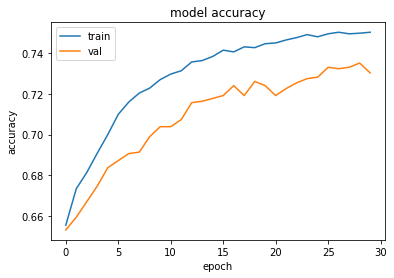

In [148]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Уже намного лучше, чем предыдущий вариант. 

## Предобученная модель с Rus vectores

Скачаем **ruscorpora_upos_cbow_300_20_2019** с rusvectores (https://rusvectores.org/ru/models/)

In [149]:
from pymystem3 import Mystem
m = Mystem()

In [150]:
def tag_mystem(text):  # from https://github.com/akutuzov/webvectors/blob/master/preprocessing/rusvectores_tutorial.ipynb

    processed = m.analyze(text)
    tagged = []
    for w in processed:
        if "analysis" not in w:
            continue
        
        if not len(w["analysis"]):
            lemma = w["text"]
            pos = "UNKN"
        else:
            lemma = w["analysis"][0]["lex"].lower().strip()
            pos = w["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        tagged.append(lemma.lower() + '_' + pos)
      
    return tagged

In [151]:
from gensim.models import KeyedVectors

In [152]:
data['tag_mystem'] = data.comment.apply(tag_mystem)

In [153]:
data.sample(5)

,comment,toxic,norm_text,tag_mystem
7496,"Я, скажем, если лечу из Германии на Урал, то у...",0.0,"[я, скажем, если, лететь, из, германия, на, ур...","[я_SPRO, скажем_ADV, если_CONJ, лететь_V, из_P..."
13230,"Первый оратор назвал Россию словом Рашка , а в...",1.0,"[первый, оратор, назвать, россия, слово, рашка...","[первый_ANUM, оратор_S, называть_V, россия_S, ..."
12316,Надо проверить свои счета\n,0.0,"[надо, проверить, свой, счёт]","[надо_ADV, проверять_V, свой_APRO, счет_S]"
4471,"Обратите внимание, там одна из подключенных ус...",0.0,"[обратить, внимание, там, один, из, подключить...","[обращать_V, внимание_S, там_ADVPRO, один_APRO..."
6767,"Не, мы лучше вас прислоним)\n",1.0,"[не, мы, хороший, вы, прислонить]","[не_PART, мы_SPRO, хороший_A, вы_SPRO, прислон..."


In [154]:
vocab_rv = Counter()

for text in data.tag_mystem:
    vocab_rv.update(text)

In [155]:
len(vocab_rv)

32925

In [156]:
word2id_rv = {'PAD': 0}

for word in vocab_rv:
    word2id_rv[word] = len(word2id_rv)

In [157]:
len(word2id_rv)

32926

In [158]:
id2word_rv = {i: word for word, i in word2id_rv.items()}

In [159]:
len(id2word_rv)

32926

In [160]:
X = []

for tokens in data.tag_mystem:
    ids = [word2id_rv[token] for token in tokens if token in word2id_rv]
    X.append(ids)

In [161]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [162]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [164]:
model = KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [165]:
weights_rv = np.zeros((len(word2id_rv), 300))

for word, i in word2id_rv.items():

    if word == 'PAD':
        continue

    try:
        weights_rv[i] = model[word]
    
    except KeyError:
        continue
        weights_rv[i] = model['опрагпллирао']

In [166]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_rv), output_dim=300, 
                                       trainable=False,
                                       weights=[weights_rv])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [167]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6349 - accuracy: 0.6622 - val_loss: 0.6109 - val_accuracy: 0.6526
Epoch 2/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6036 - accuracy: 0.6667 - val_loss: 0.6030 - val_accuracy: 0.6526
Epoch 3/30
406/406 [==============================] - 2s 5ms/step - loss: 0.5995 - accuracy: 0.6667 - val_loss: 0.6000 - val_accuracy: 0.6526
Epoch 4/30
406/406 [==============================] - 2s 6ms/step - loss: 0.5975 - accuracy: 0.6670 - val_loss: 0.5981 - val_accuracy: 0.6533
Epoch 5/30
406/406 [==============================] - 2s 5ms/step - loss: 0.5959 - accuracy: 0.6671 - val_loss: 0.5965 - val_accuracy: 0.6533
Epoch 6/30
406/406 [==============================] - 2s 5ms/step - loss: 0.5947 - accuracy: 0.6678 - val_loss: 0.5954 - val_accuracy: 0.6540
Epoch 7/30
406/406 [==============================] - 2s 5ms/step - loss: 0.5937 - accuracy: 0.6682 - val_loss: 0.5944 - val_accuracy: 0.6540
Epoch 

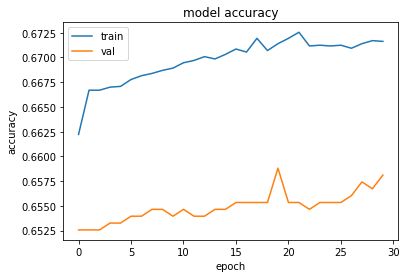

In [168]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Хорошо, но эффективность все равно низкая... Лучшие варианты оказались с эмбеддингами из 2 задания (gensim).